# Deep Neural Networks and their training

A neural network is considered "deep" if it has "many" layers (more than 5).

Shiny new methods like DNN are reported with amazing performance and accuracy. Be aware that only the best performance get put in papers, the majority of the time is spent with failures on model design and training.

A major issue with DNN stems from its dependence on the gradient of the cost functions. Because the gradients uses the chain rule with multiplication of errors in each layer, they can vanish or explode if the variance increases with each layer. It happens that the logistic function (sigmoid) having a mean of 0.5, and saturating quickly to either 0 or 1 (gradients of the sigmoid tends to zero quickly).

The training of deep neural networks is effectively a conditioning of the model weights to satisfy model accuracy, generalization, and computational efficiency. To strike that balance requires extensive tuning of hyperparameters, a goal to keep models as simple as possible, while aiming the best generalization. The conditioning of model parameters means that their values are not too small (unless intentionally sparse), mostly not too large, and that the variance of these values remains low.


This notebook covers important best practice guidelines for training deep neural networks.
* Model initialization
* Activation functions
* Batch normalization
* Optimizers
* Transfer learning
* Dropout (for training and for epistemic uncertainty calculations)

## 1. Layer initialization
Glorot and He (2010) proposes an initialization that helps lower the variance of the outputs in each layer and of the model. The number of inputs (fan<sub>in</sub> ) and the numbers of neurons (fan<sub>out</sub>). fan<sub>avg</sub> = (fan<sub>in</sub> +fan<sub>out</sub> )/2. By default, Keras uses a Glorot initialization with a uniform distribution. The following table lists the good pairing between initialization and activation functions.

| initialization | activation functions      | distribution width ($\sigma^2$)|
| -------------- | --------------------------|------------------------------- |
| Glorot         | None,tanh,logistic,softmax| 1/fan<sub>avg</sub>            |
| He             | Relu & variants           | 1/fan<sub>in</sub>             |
| LeCun          | SELU                      | 1/fan<sub>in</sub>             |

One can initialize the layers using these distributions as kernels: 

> ```python
keras.layers.Dense(300,activation="relu",kernel_initializer="he_normal")



or choose a custom layer with a He inialization of uniform distribution based out of fan<sub>ave</sub> instead of fan<sub>in</sub>:

> ```python 
init = keras.initializers.VarianceScaling(scale=2.,model='fan_avg',distribution='uniform')

> ```python 
keras.layers.Dense(300,activation="relu",kernel_initializer=my_custom_init)

More information here: https://keras.io/api/layers/initializers/


## 2. Activation functions


**sigmoid/logistic** : most popular at first for smooth activation, but their choice of saturation is not appropriate for DNN where the chain rule applied to the gradients of hte sigmoid tend to vanish.

**ReLu** : Practical, but without other regularization mechanisms (batch normalization and dropout), they tend to kill certain neurons in the network.

**LeakyReLU** : A variant of the ReLu that has a weak positive slope (hyper parameter ``alpha``) for negative values. It avoids having a strict zero for negative values and avoids the satuation and vanishing of the gradients. Outperforms ReLU. Hard to tune the hyperparameter $\alpha$. To use Leaky ReLU, you need to add a layer:

>```python
keras.layers.Dense(10,kernel_initializer="he_normal")
keras.layers.LeakyReLU(alpha=0.2)```


**Randomized Leaky ReLU - RReLU** : The hyperparameter $\alpha$ is randomized during training, fixed during testing. RRLeu acts as a regularizer and reduces the risk of overfitting.

**Parametric leaky ReLU (PReLu)**: The hyper parameter ``alpha`` is learned during training. Outperforms ReLU for large data sets, runs the risk to overfit the smaller data sets.

**Exponential Linear Unit ELU**: Instead of a linear trend in the negative values (as in the LeakyReLU), it is an exponential that smoothly saturates to a negative value. It outperforms all of the variants of ReLUs: training time reduced, never kills the neurons, smooth everywhere if ``alpha=1`` that helps speed up GD. A major drawback is the computational expense, but it is compensated by faster convergence.

**Scaled ELU - SELU** (Klambauer et al, 2017): a scaled variant of ELU. It self-normalizes the network because the output of each layer will tend to preserve a zero mean. However, it requires: input features must be standardized (mean 0, std=1), initialization of weights must be LeCun normal (``kernel_initializer="lecun_normal"``), network must be sequential (no skip connection, nor RNN, no wide nets), layers must be dense.


Text(0.5, 1.0, 'activation functions')

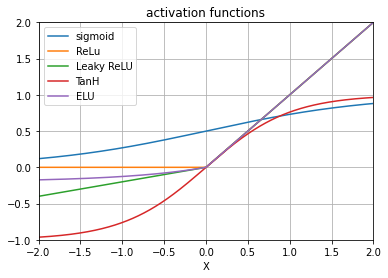

In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

x=np.linspace(-2,2,1000)

def sigm(x): # define the sigmoid function
    return 1/(1+np.exp(-x))
def relu(x): # define the Rectified Linear Unit function
    return   np.maximum(x,0)
def Leakyrelu(a,x): # define the Leaky Rectified Linear Unit function
    return  np.maximum(x,a*x)

def Leakyrelu(a,x): # define the Leaky Rectified Linear Unit function
    return  np.maximum(x,a*x)

def elu(a,x): # define the Exponential Linear Unit function
    return  np.maximum(x,a*(np.exp(x)-1))
                       
s = sigm(x)
t = np.tanh(x)
r = relu(x)
lr = Leakyrelu(0.2,x)
e = elu(0.2,x)

plt.plot(x,s)
plt.plot(x,r)
plt.plot(x,lr)
plt.plot(x,t)
plt.plot(x,e)
plt.grid(True)
plt.legend(['sigmoid','ReLu','Leaky ReLU','TanH','ELU'])
plt.xlim([-2,2])
plt.xlabel('X')
plt.ylim([-1,2])
plt.title('activation functions')

In general, the preferred choice should be:

**SELU (if dense and sequential) > ELU > Leaky ReLU (and variants) > ReLU > tanh > logistic.**




ReLU is the most implemented, and most packages have optimizers that best perform on ReLU, so a safe choice is ReLU. More information here: https://keras.io/api/layers/activation_layers/

# 3. Batch Normalization

The BN layer standardizes the inputs (shift and normalize the outputs of the layers). It adds parameters and complexity to the network. The benefits are:
* it reduces vanishing/exploding gradients (one can now use saturating activation functions),
* networks are less sensitive to the weight initialization,
* one can use larger learning rates,
* they act as a regularizer (reducing the need for regularization and dropout). 

Tips for its implementation:
* Whether the BN layer should be before or after the activation function seems to depend on the task, so one has to experiment with each data set.
* To add the BN layer before the activation function, you must remove the activation function from the hidden layers and add them separately 
* Because BN removes the bias term from the previous layers, you can remove the bias term from the previous layers ``use_bias=False``.
* the hyperparameter ``momentum``  that is used to update the averages <1 but close to one 0.999s for large data sets and small mini batches.
* BN layers by default acts on one axis, use the argument ``axis=[1,2]`` for 2D input batch (or flatten your 2D input batch to 1D).

Here is an example:

In [10]:
import tensorflow as tf
from tensorflow import keras

In [11]:
model = keras.models.Sequential( [
keras.layers.Flatten(input_shape=[28,28]), # reshape the 2D matrix into a 1D vector, without modifying the values
keras.layers.BatchNormalization(),
keras.layers.Dense(300,kernel_initializer="he_normal",use_bias=False), # single dense layer, downsampling from input layer to this year from 784 points to 300.
keras.layers.BatchNormalization(),
keras.layers.Activation("relu"),
keras.layers.Dense(100,kernel_initializer="he_normal",use_bias=False), # 100 neurons
keras.layers.BatchNormalization(),
keras.layers.Activation("relu"),
keras.layers.Dense(10,activation="softmax") ]) # output layer, 10 neurons since there are 10 classes.
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense (Dense)                (None, 300)               235200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
activation (Activation)      (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30000     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               4

# 4. Clipping the gradients
If Batch Normalization is tricky to use (e.g. in RNNs), one can simply clip the gradients so that they do not explode. You can clip the value of the gradients by a tunable/hyperparameter value ``clipvalue=1.0`` or by the L2 norm of the gradients ``clipnorm=1.0`` (it preserves the orientation of the gradient. Try both and see what works best.

In [ ]:
alpha = 0.005# learning rate lr
optimizer = keras.optimizers.SGD(lr=alpha,clipvalue=1.0) # stochastic gradient descent

# 5. Transfer learning

Transfer learning is useful to improve model generalization, continue training networks, modify already trained networks and adapt. 


In [13]:
model_A = keras.models.load_model("my_first_NN_model.h5")
print(model_A.summary())

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 784)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 784)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 300)               235500    
_________________________________________________________________
dropout_4 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 100)               30100     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 10)              

In [14]:
model_B_on_A = keras.models.Sequential(model_A.layers[:-1]) # use all of the network exept the last year.
print(model_B_on_A.summary())
model_B_on_A.add(keras.layers.Dense(10,activation="softmax")) # this is your new model: here i reset the output layer
print(model_B_on_A.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 784)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 784)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 300)               235500    
_________________________________________________________________
dropout_4 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 100)               30100     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
Total params: 265,600
Trainable params: 265,600
Non-trainable params: 0
________________________________________________

In [7]:
model_A_clone = keras.models.clone_model(model_A) # CLONE MODELS TO AVOID OVERWRITING!
model_A_clone.set_weights(model_A.get_weights()) # COPY THE WEIGHT

Training model_B_on_A will modify  model_A, thus one has to clone model_A to keep an unmodified version.

When you retrain but modified and added layers, there is an inbalance of weights or information: the old model is already optimized, the new layers are random. One can freeze the pre-trained layers to force the training on the newly added layers during a few epochs. One can freeze layers by switching the status of the parameters "trainable" from "True" to "False"  

In [8]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable=False
print(model_B_on_A.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 784)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 784)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 300)               235500    
_________________________________________________________________
dropout_4 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 100)               30100     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

In [9]:
alpha = 0.005# learning rate lr
optimizer = keras.optimizers.SGD(lr=alpha) # stochastic gradient descent
model_B_on_A.compile(loss="sparse_categorical_crossentropy",
             optimizer=optimizer,
             metrics="accuracy")

Train on a few epochs, then unfreeze the weights

In [10]:
# load the fashion MNIST data. it's boring, but it works!
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()
class_names = ["tshirt","trousers","pullover","dress","coat","sandal","shirt","sneaker","bag","boot"]
X_val,X_train = X_train_full[:5000]/255.0,X_train_full[5000:]/255.0
y_val,y_train = y_train_full[:5000],y_train_full[5000:]

In [11]:
history = model_B_on_A.fit(X_train,y_train,epochs=4,validation_data=(X_val,y_val))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable=True
    
model_B_on_A.compile(loss="sparse_categorical_crossentropy",
             optimizer=optimizer,
             metrics="accuracy")
history = model_B_on_A.fit(X_train,y_train,epochs=16,validation_data=(X_val,y_val))

Epoch 1/4
1719/1719 [==============================] - 2s 1ms/step - loss: 0.9090 - accuracy: 0.7552 - val_loss: 0.2985 - val_accuracy: 0.8984
Epoch 2/4
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3264 - accuracy: 0.8881 - val_loss: 0.2867 - val_accuracy: 0.9000
Epoch 3/4
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2945 - accuracy: 0.8956 - val_loss: 0.2802 - val_accuracy: 0.9000
Epoch 4/4
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2962 - accuracy: 0.8929 - val_loss: 0.2786 - val_accuracy: 0.9032
Epoch 1/16
1719/1719 [==============================] - 3s 1ms/step - loss: 0.2810 - accuracy: 0.8985 - val_loss: 0.2724 - val_accuracy: 0.9040
Epoch 2/16
1719/1719 [==============================] - 3s 1ms/step - loss: 0.2684 - accuracy: 0.9006 - val_loss: 0.2707 - val_accuracy: 0.9070
Epoch 3/16
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2586 - accuracy: 0.9023 - val_loss: 0.2703 - val_accuracy: 0.9

Fully connected DNNs tend to not generalize well. Transfer learning works best with deep CNNs.

# Optimizers

Training is super slow. You can speed up training with the following strategies:
* good initialization
* good activation function
* use Batch Normalization
* use Lasso Regression for sparse models.

Optimizer comparisons:
* **SGD**. Slow convergence speed but high convergence quality. Default in keras is ``keras.optimizers.SGD()``. Default is constant learning rate, but one can impose an evolution of the learning rate as training goes. ``keras.optimizers.SGD(lr=0.01,decay=1e-4)`` implements are power scheduling of the learning rate $\eta$ ,$\eta(t)=\eta_0/(1+t/s)^c$, where $c$ is the power of the decay ($1/s$). There are other functions that can be implemented, check out the Keras information: https://keras.io/api/callbacks/learning_rate_scheduler/
* **momentum optimization**. The weights are updated by a momentum vector that carries the sum of the gradients, it's a lot faster though bounces around a bit at the end.  ``keras.optimizers.SGD(lr=0.001,momentum=0.9)``. Usually 0.9 works great, but it should be tuned as a hyperparmeter
* **Nesterov Accelerated Gradient**. It's momentum + the gradient of the momentum. NAG is much faster than momentum GD. ``keras.optimizers.SGD(lr=0.001,momentum=0.9,nesterov=True)``.
* **AdaGrad**. It scales the gradient vector to the steepest dimensions. It has an *adaptive learning rate* because the learning rate depends on the cost function gradient itself. One issue with neural networks is that the learning rate becomes too small, so do NOT use it for DNN.
* **Adam Optimization (best choice)**: adaptive moment estimation. It uses both momentum (beta_1 hyper parameter) and sum of gradients (beta_2) as scaling mechanisms for updating the weights. Good default values are : ``keras.optimizers.Adam(lr=0.001,beta_1=0.9,beta_2=0.999)``.

# Avoiding Overfitting for training DNNs

## Regularizations
Use l_1 and l_2 regularizations to constrain the connection weights. Use l_1 to force a sparse model. To implement a regularization on each layer, 

In [34]:
keras.layers.Dense(100,activation="elu",kernel_initializer="he_normal",\
                   kernel_regularizer=keras.regularizers.l2(0.01)) # this is your new model: here i reset the output layer

Because stacking layers means calling the keras functions with many hyperparameters, typing each layer by hand is prone to typos and errors. It is recommended to write functions to wrap these calls. In Python, the function ``functools.partial()`` can perform just that.

In [35]:
from functools import partial
RegDense = partial(keras.layers.Dense,
                   activation="relu",
                   kernel_initializer="he_normal",
                   kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential( [
keras.layers.Flatten(input_shape=[28,28]), # reshape the 2D matrix into a 1D vector, without modifying the values
RegDense(300),
RegDense(100),
RegDense(10,activation="softmax",kernel_initializer="glorot_uniform") ]) # output layer, 10 neurons since there are 10 classes.
print(model.summary())

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 300)               235500    
_________________________________________________________________
dense_23 (Dense)             (None, 100)               30100     
_________________________________________________________________
dense_24 (Dense)             (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________
None


# Dropout

Most popular regularization technique for DNN. It is muting a portion of the neurons during the training, forcing the gradients to pass through neurons that could be otherwise ignored.

![Multi Layer Perceptron](dropout2.svg)

Monte Carlo Dropout serves the other purpose ot estimating an ensemble of testing. We make N predections over the test set, setting ``training=True`` to ensure that the dropout layer is still active and stack the predictions. Because the dropout is active, all the predictions woll be different. Averaging over multiple predictions with dropout gives us a MC estimate that is more reliable than the result of a single prediction.

### marine will update this section

In [12]:
model = keras.models.Sequential( [
keras.layers.Flatten(input_shape=[28,28]), # reshape the 2D matrix into a 1D vector, without modifying the values
keras.layers.Dropout(rate=0.2),
keras.layers.Dense(300,activation="relu"), # 
keras.layers.Dropout(rate=0.2),
keras.layers.Dense(100,activation="relu"), # 100 neurons
keras.layers.Dropout(rate=0.2),
keras.layers.Dense(10,activation="softmax") ]) # output layer, 10 neurons since there are 10 classes.
alpha = 0.005# learning rate lr
optimizer = keras.optimizers.Adam(lr=0.001,beta_1=0.9,beta_2=0.999)

In [13]:
model.compile(loss="sparse_categorical_crossentropy",
             optimizer=optimizer,
             metrics="accuracy")

In [14]:
# checkpoints_cb = keras.callbacks.ModelCheckpoint("my_first_NN_model.h5",save_best_only=True)
# with the argument save_best_only, the checkpoint saved will be one that of best performance according to the performance metrics chosen.
history = model.fit(X_train,y_train,epochs=30,validation_data=(X_val,y_val))

Epoch 1/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.7496 - accuracy: 0.7258 - val_loss: 0.4039 - val_accuracy: 0.8554
Epoch 2/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4648 - accuracy: 0.8286 - val_loss: 0.3678 - val_accuracy: 0.8668
Epoch 3/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4165 - accuracy: 0.8466 - val_loss: 0.3525 - val_accuracy: 0.8734
Epoch 4/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3932 - accuracy: 0.8533 - val_loss: 0.3384 - val_accuracy: 0.8796
Epoch 5/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3777 - accuracy: 0.8596 - val_loss: 0.3319 - val_accuracy: 0.8740
Epoch 6/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3693 - accuracy: 0.8622 - val_loss: 0.3219 - val_accuracy: 0.8802
Epoch 7/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3561 - accuracy: 0.8662 - val_loss: 0.3194 - val_accuracy: